In [63]:
# financial data analysis with arhmm

In [64]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [65]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

import numpy as np
import pandas as pd

In [66]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### loading the dataset

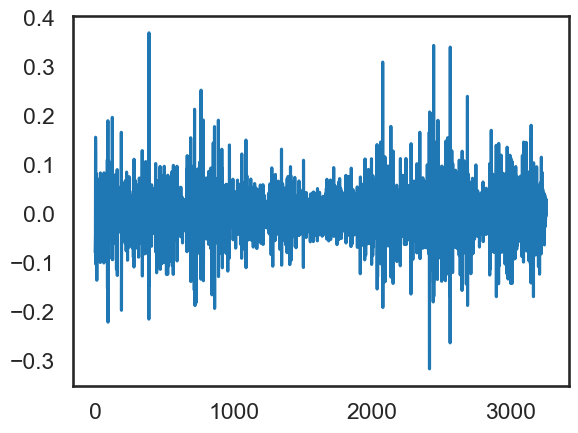

In [67]:
data = pd.read_csv("Financial-Data/stocks/TSLA.csv")
data = data.dropna()
data.head()

close_diff = np.diff(np.log(data['Close']))[1:]
close_diff_1 = np.diff(np.diff(np.log(data['Close'])))

plt.plot(close_diff_1)

## fitting a model

In [68]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 3
emission_dim = 1
num_lags = 1

emissions = jnp.array(close_diff).reshape(-1, 1)


# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

inputs = arhmm.compute_inputs(emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot the log-likelihood

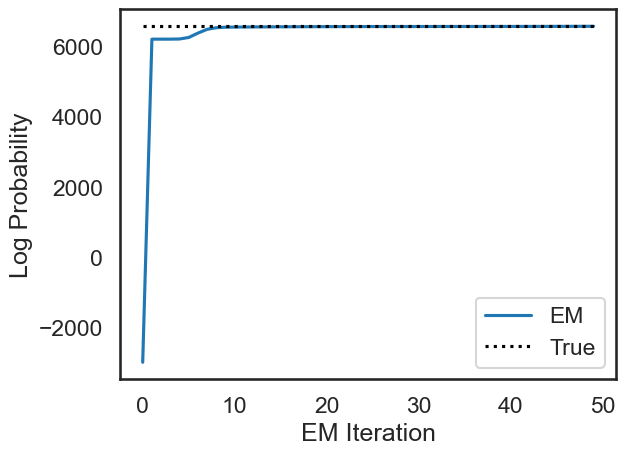

In [69]:
true_lp = arhmm.marginal_log_prob(fitted_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

## inspecting the parameters

In [70]:
# inspecitng the fitted parameters
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.84608763, 0.07698458, 0.07692778], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.77651495, 0.07144035, 0.1520447 ],
       [0.04124827, 0.50886977, 0.4498819 ],
       [0.14512634, 0.786215  , 0.06865867]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.00449705]],

       [[ 0.07297212]],

       [[-0.07526093]]], dtype=float32), biases=Array([[0.00085269],
       [0.0008614 ],
       [0.00325267]], dtype=float32), covs=Array([[[0.00351961]],

       [[0.00057859]],

       [[0.0003477 ]]], dtype=float32))


# find most likely states

In [71]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

# sample new data and plot them

NameError: name 'ax' is not defined

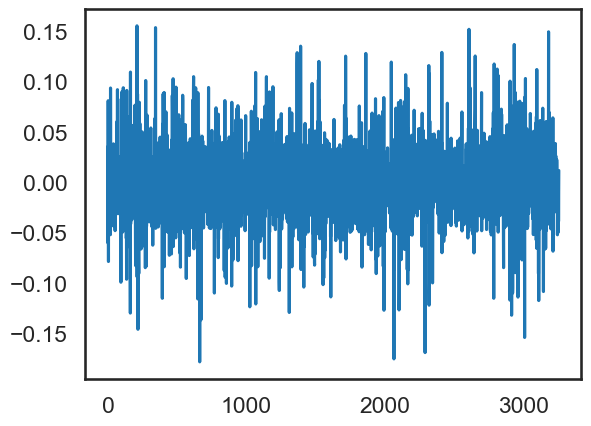

In [72]:
time_bins = len(emissions)
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)

plt.plot(sampled_emissions)
ax[0].plot(emissions, color="black", label="True")
ax[0].plot(sampled_emissions, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")

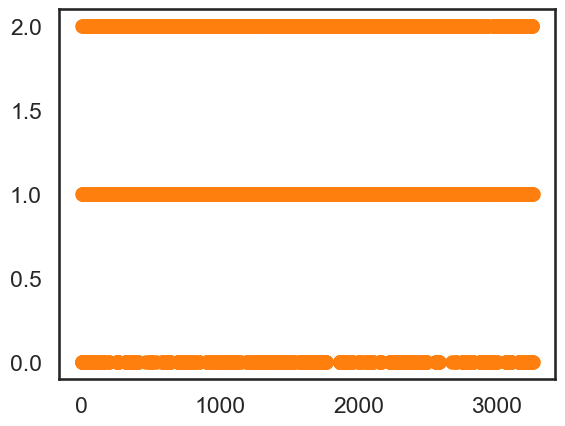

In [ ]:
plt.scatter(np.arange(len(most_likely_states)),most_likely_states, s=1) # size of the dot smaller

plt.scatter(np.arange(len(most_likely_states)),sampled_states)


(array([ 930., 1594.,  735.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

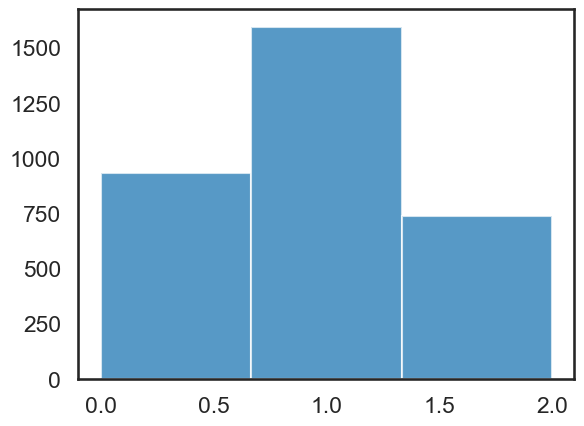

In [ ]:
plt.hist(most_likely_states, bins=num_states, alpha=0.75)

Text(0.5, 0, 'time')

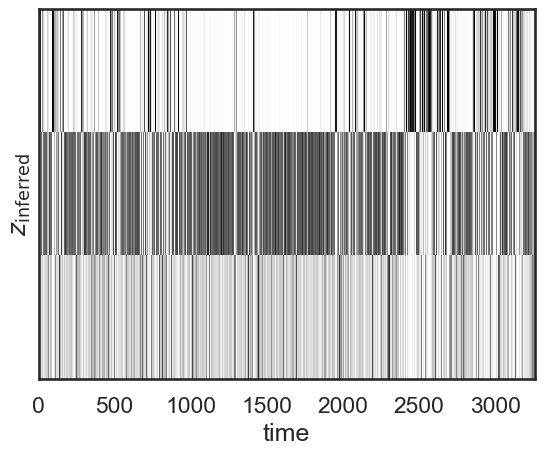

In [ ]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

In [ ]:
print(posterior.smoothed_probs)

[[9.6177977e-01 1.9344656e-02 1.8875616e-02]
 [9.9302387e-01 7.4980317e-06 6.9686258e-03]
 [9.9979597e-01 2.7270401e-13 2.0406484e-04]
 ...
 [6.8068586e-02 7.1735030e-01 2.1458113e-01]
 [1.6063003e-01 3.7206033e-01 4.6730968e-01]
 [2.0909350e-01 4.3121788e-01 3.5968858e-01]]
